    This is the jupyter notebook used for plotting soil-to-rock spectral ratios 
    of Nepal basin in Oral et al. (2022) 
    https://doi.org/10.1093/gji/ggac302
    
    The two examples here use "Ricker" input, nonlinear soil, and only differ by incidence angle.

# 1) Import libraries
* Modify the path to JUPYTER

In [1]:
%matplotlib notebook

import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
from  matplotlib import colors
from matplotlib.pylab import cm 
import colorcet

sys.path.append('/Users/elifo/Work/SOFT/sem2dpack/JUPYTER/')
sys.path.append('/Users/elifo/Work/SOFT/sem2dpack/JUPYTER/modules/')
from Class_sem2dpack import *

# 2) Input data
* Directory with output files
* Frequency band 
* Basin length range to distinguish basin inside/outside (or soil/rock)

In [2]:
# Directory names with output files
direct1 = '../../EXAMPLES/SiteEffects/Oraletal2022_Nepal_vertical_incidence_nonlinear_basin/'
direct2 = '/Volumes/LaCie/ELIF/Nepal/Simulation_files/THETA_30/RICKER_NONLI_CORR/'

comp = 'x'
fmin, fmax = 0.01, 10.0
taper = 0 # no-tapering

# to distinguish bedrock for geometric mean
# of rock response; I avoid topo part.
basin_beg, basin_end = 10e3, 35e3


# only for plotting
# to show basin limits in the plot
basin_limit_left, basin_limit_right = 13.0491, 31.41007
# real station coordinates 
TVU_x, TVU_z = 13865.468512, -32.918928
THM_x, THM_z = 23100.786545, -6.334260

# 3) Read and process output signals

In [3]:
# initiate the class SEM
SEM1 = sem2dpack(direct1)
# read seismograms
SEM1.read_seismo(component=comp)
# filter
SEM1.filter_seismo(fmax=fmax, ftype='lowpass')
SEM1.filter_seismo(fmin=fmin, ftype='highpass')
print ('*')



SEM2 = sem2dpack(direct2)
# read seismograms
SEM2.read_seismo(component=comp)
# filter
SEM2.filter_seismo(fmax=fmax, ftype='lowpass')
SEM2.filter_seismo(fmin=fmin, ftype='highpass')
print ('*')

##

Reading grid information...
Reading header file...
0.003 6667 5977
Extra station number:  6005
*
Filtering seissmograms ...
Filtering seissmograms ...
*
Reading grid information...
Reading header file...
0.003 6667 5977
Extra station number:  36015
*
Filtering seissmograms ...
Filtering seissmograms ...
*


# 4) Compute soil-to-rock spectral ratio 

In [4]:
def compute_Nepal_basin_transfer_function(self, fmax=10.1, nsample=1500, basin_beg=0.0, basin_end=0.0):
    
    # indices of bedrock, basin, and all the stations that are used
    cdt1 = (self.rcoord[:,0] <= basin_beg) | (self.rcoord[:,0] >= basin_end)
    bedrock_index = [ii for ii in np.where(cdt1)[0]]
    bedrock_index = [bedrock_index[ii] for ii in range(0,len(bedrock_index),1)]

    cdt2 = (self.rcoord[:,0] > basin_beg) & (self.rcoord[:,0] < basin_end)
    basin_index = [ii for ii in np.where(cdt2)[0]]
    basin_index = [basin_index[ii] for ii in range(0,len(basin_index),18)]

    l = bedrock_index+ basin_index
    ind = list(set(l))
    ind.sort()

    # x coordinates that interest us
    xx = self.rcoord[ind,0] 

    # geometric mean of bedrock    
    bedrock_mean = []
    for ii in bedrock_index:
        amp = self.velocity[:,ii]
        dt = self.dt
        inspec,f = fourier(amp,dt, p=taper)   
        inputf, inspec = ko(inspec, dt, f[1]-f[0], fmax=fmax, bexp=40.0)
        bedrock_mean.append(np.log10(inspec)) 
    #
    bedrock_mean = sum(bedrock_mean)/len(bedrock_mean)
    bedrock_mean = 10**bedrock_mean    
    inspec = bedrock_mean

    # FFT of all stations
    tf = []; fft = []; 
    for i in ind:
        vel = self.velocity[:,i]
        spec,f = fourier(vel, self.dt, p=0)
        freq, spec = ko(spec, self.dt, f[1]-f[0], fmax=fmax, bexp=40.0)
        fft.append(spec)
        tf.append(spec/inspec)
    #
    fft = np.array(fft)
    tf = np.array(tf)
    print ('tf', tf.shape)

    # interpolation    
    _xi = np.linspace(xx.min(), xx.max(),nsample)
    _yi = np.linspace(freq.min(), freq.max(), nsample)
    xi, yi = np.meshgrid(_xi, _yi)

    data = tf.flatten().T 
    _x, _y = np.meshgrid(xx, freq)
    chain = np.vstack((_x.T.flatten(), _y.T.flatten())).T
    data = gd(chain, data, (xi,yi), method='linear')
    
    print ('*')
    return inputf, inspec, freq, data, xx
#     return inputf, inspec, freq, data, xx, xi, yi, chain

###

In [5]:
# Compute transfer function of basin stations
# nsample: sample nb to use in iterpolation of 2D figure
inputf1, inspec1, freq1, data1, xx = compute_Nepal_basin_transfer_function(SEM1, fmax=fmax+0.1, nsample=1500, 
                                                        basin_beg=basin_beg, basin_end=basin_end)


inputf2, inspec2, freq2, data2, xx2 = compute_Nepal_basin_transfer_function(SEM2, fmax=fmax+0.1, nsample=1500, 
                                                        basin_beg=basin_beg, basin_end=basin_end)


tf (597, 201)
*
tf (597, 201)
*


# 5) 2D Plot

<IPython.core.display.Javascript object>


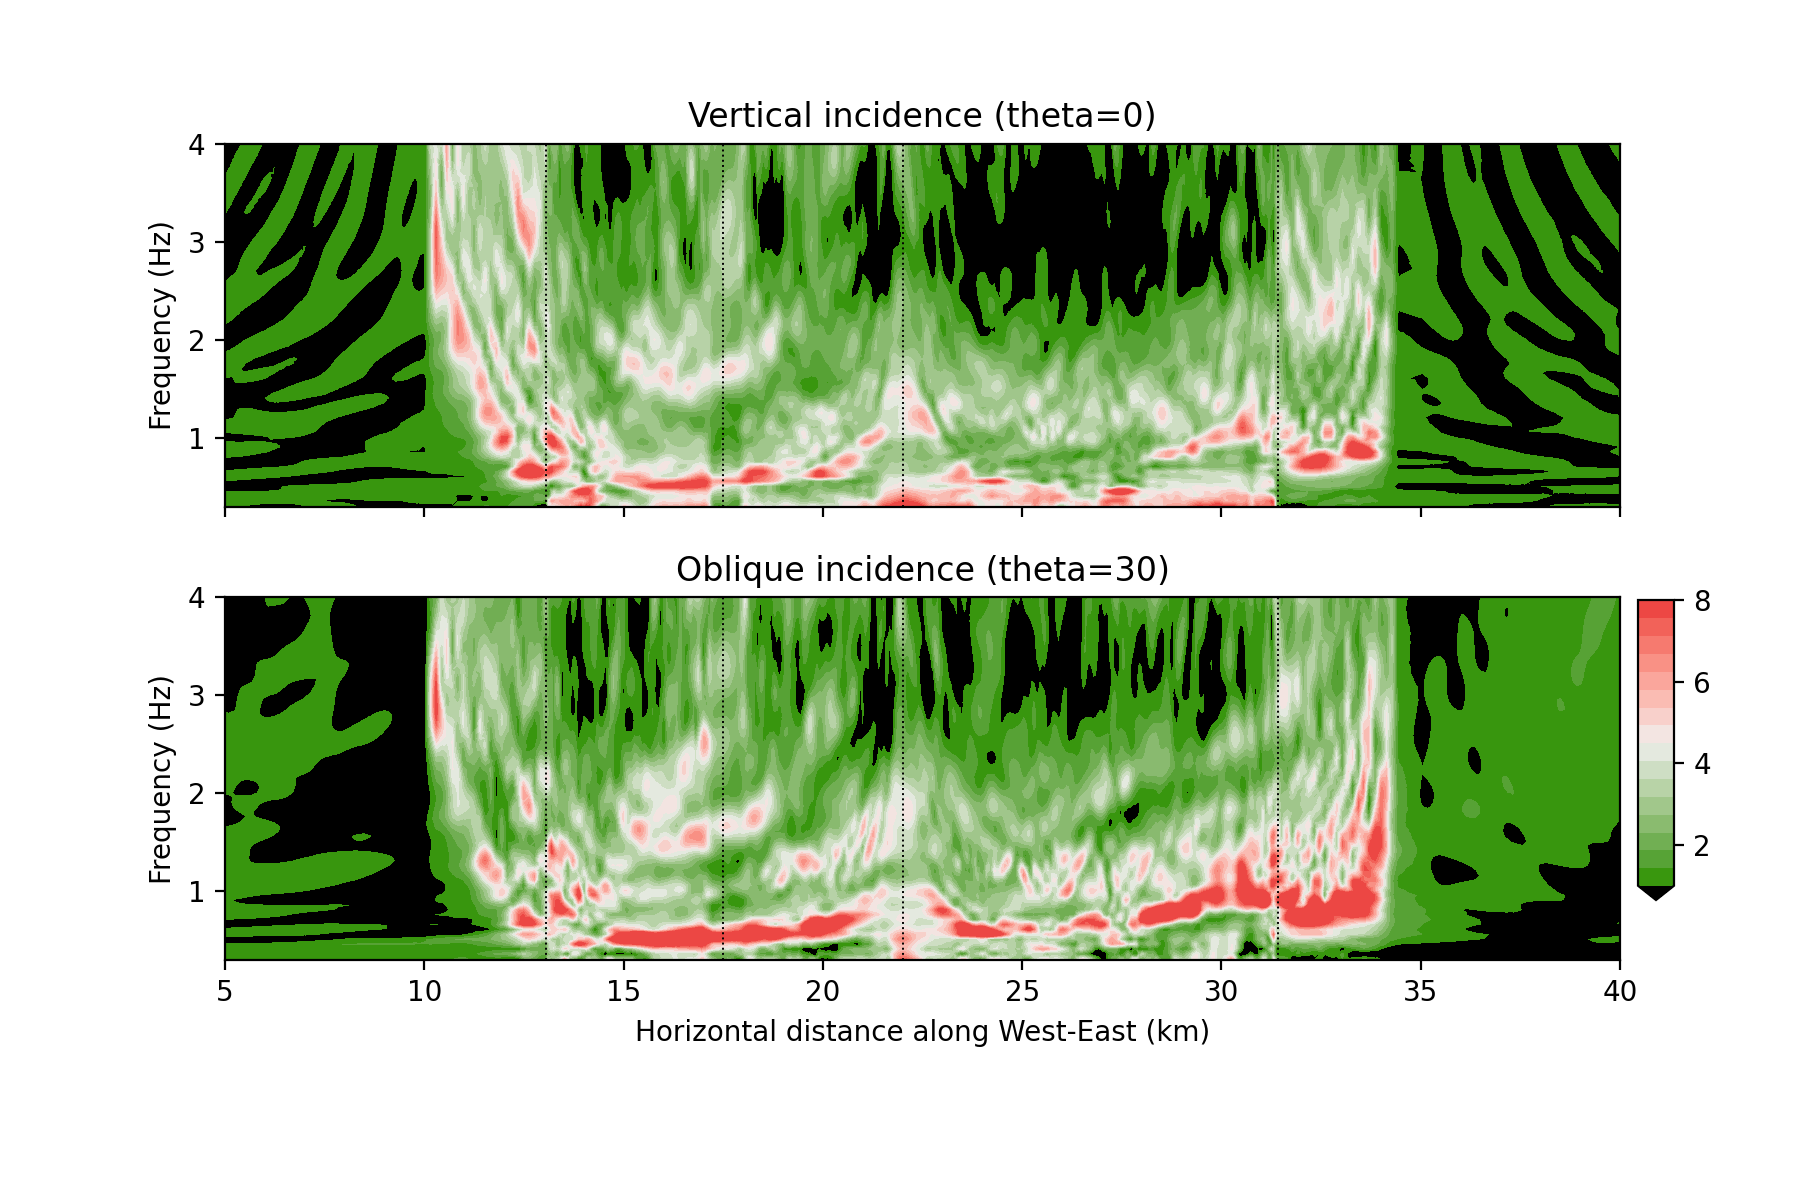

In [11]:
# 2D plot here
vmax = 8.0
vmin = 1.0
_aspect = 'auto'
ylim1 = 0.3
ylim2 = 4.0
_clim = 'k'
title1, title2 = 'Vertical incidence (theta=0)', 'Oblique incidence (theta=30)'

cmap = cm.get_cmap('cet_CET_D3', 16)    # n discrete colors
# ### MAKE 0-1 EASIR TO NOTICE ###
cmap.set_under('k')
_cmap= cmap
 


###
plt.close('all')
fig = plt.figure(figsize=(9,6)); #set_style(whitegrid=False)
# plt.suptitle('Site-to-rock spectral ratio for different nonlinearity levels \n')
ext = [xx.min()/1e3, xx.max()/1e3, fmin, fmax]

### case 1
ax = fig.add_subplot(211) 
ax.set_title(title1)
ax.set_ylim(ylim1, ylim2); 
ax.set_xlim(basin_beg/1e3- 5, basin_end/1e3+ 5)
# ax.set_xlabel('Horizontal \ndistance \n(km)'); #ax.set_ylabel('Frequency (Hz)')
im = ax.imshow(data1, origin='lower', extent=ext,\
               vmin=vmin, vmax=vmax, cmap=_cmap, aspect=_aspect)    

ax.axvline(x=basin_limit_left, c=_clim, linestyle=':', lw=0.7)
ax.axvline(x=basin_limit_right, c=_clim, linestyle=':', lw=0.7)
ax.axvline(x=17.5e0, c=_clim, linestyle=':', lw=0.7)
ax.axvline(x=22.0e0, c=_clim, linestyle=':', lw=0.7)
ax.tick_params(labelbottom=False)
ax.set_ylabel('Frequency (Hz)')

### case 2
ax2 = fig.add_subplot(212, sharex=ax) 
ax2.set_title(title2)
ax2.set_ylim(ylim1, ylim2); 
ax2.set_xlim(basin_beg/1e3- 5, basin_end/1e3+ 5)
# ax2.set_xlabel('Horizontal \ndistance \n(km)'); #ax.set_ylabel('Frequency (Hz)')
im = ax2.imshow(data2, origin='lower', extent=ext,\
               vmin=vmin, vmax=vmax, cmap=_cmap, aspect=_aspect)    

ax2.axvline(x=basin_limit_left, c=_clim, linestyle=':', lw=0.7)
ax2.axvline(x=basin_limit_right, c=_clim, linestyle=':', lw=0.7)
ax2.axvline(x=17.5e0, c=_clim, linestyle=':', lw=0.7)
ax2.axvline(x=22.0e0, c=_clim, linestyle=':', lw=0.7)
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlabel('Horizontal distance along West-East (km)')


# cbar 
fig.subplots_adjust(right=0.9, bottom=0.2, wspace=0.1, hspace=0.25)
cbar_ax = fig.add_axes([0.91, 0.25, 0.02, 0.25]) #[left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, extend='min')

plt.show()
##

In [ ]:
#